                                      # CAPSTONE PROJECT              


In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd


# Amazon URL and headers
url = "https://www.amazon.in/s?k=mobile+phones"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)",
    "Accept-Language": "en-US,en;q=0.9"
}

# Get response and parse
response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.content, "html.parser")

# Extract product blocks
products = soup.find_all("div", {"data-component-type": "s-search-result"})

names, prices, ratings, rams, storages = [], [], [], [], []

for item in products:
    # Product name
    name = item.h2.text.strip() if item.h2 else "N/A"
    names.append(name)

    # Price
    price_tag = item.find("span", class_="a-price-whole")
    prices.append(price_tag.text.replace(",", "") if price_tag else "0")

    # Rating
    rating_tag = item.find("span", class_="a-icon-alt")
    ratings.append(rating_tag.text.split()[0] if rating_tag else "0")

    # Extract RAM and Storage using regex from name
    ram_match = re.search(r"(\d+)\s*GB\s*RAM", name, re.IGNORECASE)
    storage_match = re.search(r"(\d+)\s*GB\s*(Storage|ROM)", name, re.IGNORECASE)

    rams.append(ram_match.group(1) + " GB" if ram_match else "N/A")
    storages.append(storage_match.group(1) + " GB" if storage_match else "N/A")

# Create DataFrame
df = pd.DataFrame({
    "Name": names,
    "Price": pd.to_numeric(prices, errors="coerce"),
    "Rating": pd.to_numeric(ratings, errors="coerce"),
    "RAM": rams,
    "Storage": storages
})

# Show results
print(df.head(10))

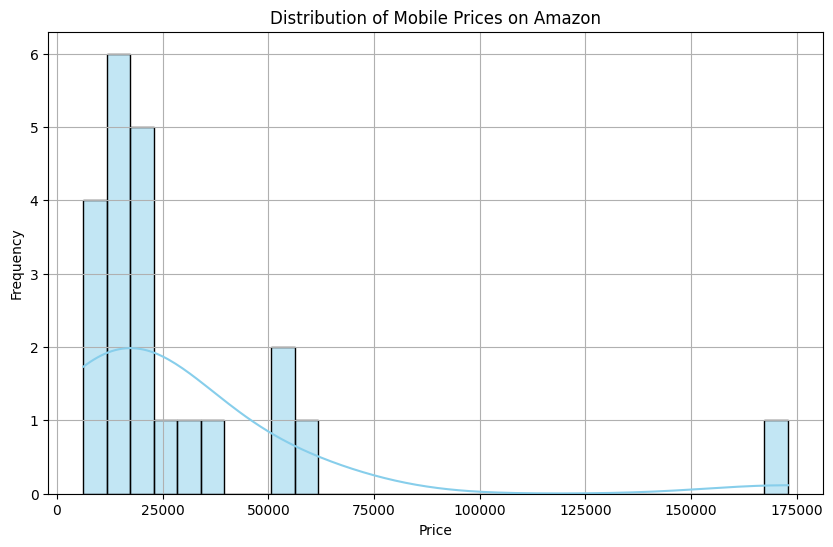

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df['Price'].dropna(), bins=30, kde=True, color='skyblue')
plt.title('Distribution of Mobile Prices on Amazon')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [63]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Use your existing DataFrame: df
# First, clean up the RAM and Storage columns
df_clean = df.copy()

# Remove "GB" and convert to numeric
df_clean["RAM"] = df_clean["RAM"].str.replace(" GB", "").replace("N/A", "0").astype(int)
df_clean["Storage"] = df_clean["Storage"].str.replace(" GB", "").replace("N/A", "0").astype(int)

# Drop any rows with missing or zero price
df_clean = df_clean[df_clean["Price"] > 0]

# Select features for clustering
X = df_clean[["Price", "Rating", "RAM", "Storage"]]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [64]:
df.isnull().sum()

Name       0
Price      0
Rating     0
RAM        0
Storage    0
dtype: int64

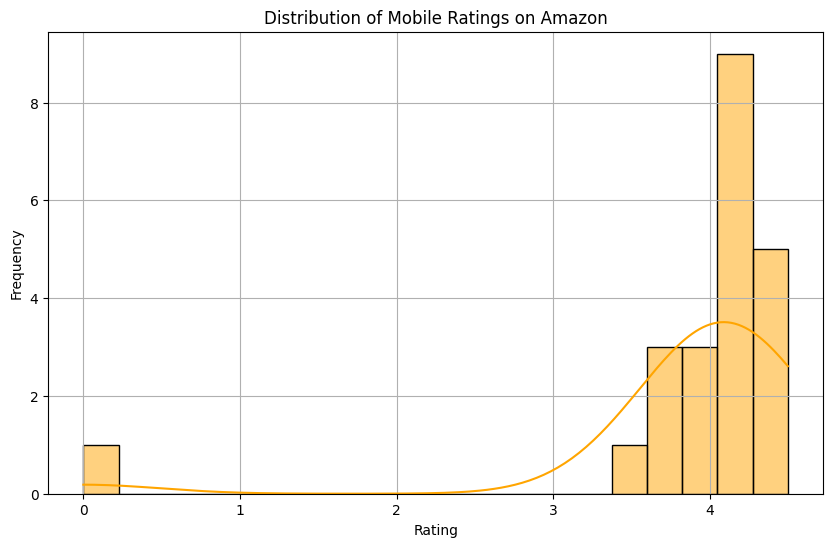

In [65]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Rating'].dropna(), bins=20, kde=True, color='orange')
plt.title('Distribution of Mobile Ratings on Amazon')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

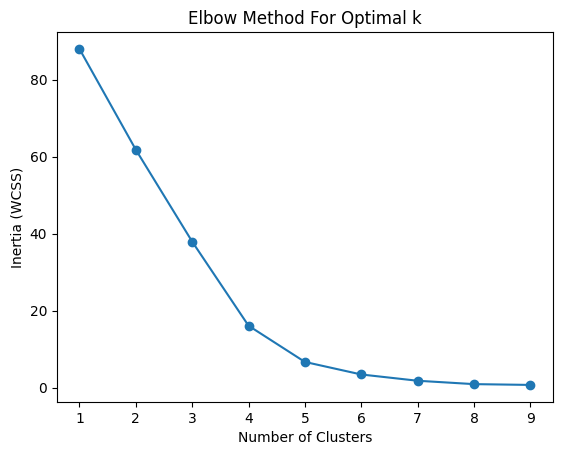

In [66]:
# Elbow method to determine k
inertia = []
K = range(1, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Method For Optimal k")
plt.show()


In [67]:
kmeans = KMeans(n_clusters=3, random_state=0)
df_clean["Cluster"] = kmeans.fit_predict(X_scaled)


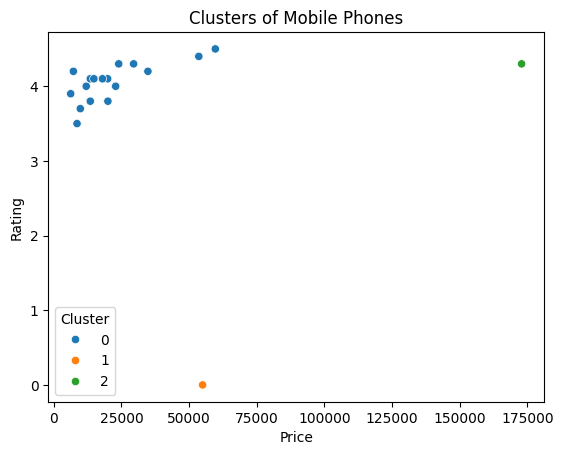

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

# Color the scatter plot by cluster
sns.scatterplot(data=df_clean, x="Price", y="Rating", hue="Cluster", palette="tab10")
plt.title("Clusters of Mobile Phones")
plt.show()


In [69]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Assume you already have a DataFrame `df` with RAM and Storage extracted
df_model = df.copy()

# Clean RAM and Storage
df_model["RAM"] = df_model["RAM"].str.replace(" GB", "").replace("N/A", "0").astype(int)
df_model["Storage"] = df_model["Storage"].str.replace(" GB", "").replace("N/A", "0").astype(int)
df_model["Price"] = pd.to_numeric(df_model["Price"], errors="coerce")
df_model["Rating"] = pd.to_numeric(df_model["Rating"], errors="coerce")
df_model = df_model.dropna()

# Create price segments
def price_category(price):
    if price < 10000:
        return "Low"
    elif price < 20000:
        return "Medium"
    else:
        return "High"

df_model["Price_Category"] = df_model["Price"].apply(price_category)

# Features and Target
X = df_model[["RAM", "Storage", "Rating"]]
y = df_model["Price_Category"]

# Encode target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)


In [70]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


In [71]:
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

        High       1.00      0.50      0.67         4
         Low       0.00      0.00      0.00         1
      Medium       0.50      1.00      0.67         2

    accuracy                           0.57         7
   macro avg       0.50      0.50      0.44         7
weighted avg       0.71      0.57      0.57         7

Confusion Matrix:
 [[2 1 1]
 [0 0 1]
 [0 0 2]]


In [72]:
# Define model
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
from sklearn.model_selection import GridSearchCV

# Define hyperparameters to search
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10]
}

# Grid search
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
best_rf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 50}


In [73]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

df["RAM"] = df["Name"].str.extract(r'(\d+)\s*GB\s*RAM', expand=False)
df["Storage"] = df["Name"].str.extract(r'(\d+)\s*GB\s*(?:Storage|ROM)', expand=False)

df["Brand"] = df["Name"].str.split().str[0]
df = pd.get_dummies(df, columns=["Brand"], drop_first=True)
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor()
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
df["Brand"] = df["Name"].str.extract(r'^(\w+)', expand=False)
df = pd.get_dummies(df, columns=["Brand"], drop_first=True)

X_tfidf = tfidf.fit_transform(df["Name"])

X_tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

X_combined = pd.concat([
    X_tfidf_df.reset_index(drop=True),
    df[["RAM", "Storage", "Rating"]].reset_index(drop=True)
], axis=1)

X_combined = X_combined.dropna()
y = df.loc[X_combined.index, "Price"]  # Align y with valid X_combined rows


X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

model = RandomForestRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("R² Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))


NameError: name 'tfidf' is not defined

In [ ]:
import joblib
joblib.dump(best_rf, "mobile_price_model.pkl")


['mobile_price_model.pkl']

In [ ]:
data = {
    "RAM": [4, 6, 8],
    "Storage": [64, 128, 256],   
    "Rating": [4.0, 4.5, 3.9]
}
df = pd.DataFrame(data)

sample = pd.DataFrame({
    "RAM": [8],
    "Storage": [128],
    "Rating": [4.5]
    # Add other required columns if your model expects them
})
predicted_price = best_rf.predict(sample)

print(predicted_price)

[29396.70927517]


In [ ]:
samples = pd.DataFrame({
    "RAM": [4, 6, 8],
    "Storage": [64, 128, 256],
    "Rating": [4.2, 4.4, 4.6]
})
predicted_prices = best_rf.predict(samples)
print(predicted_prices)

[20709.99331913 29188.71727517 33081.78953491]


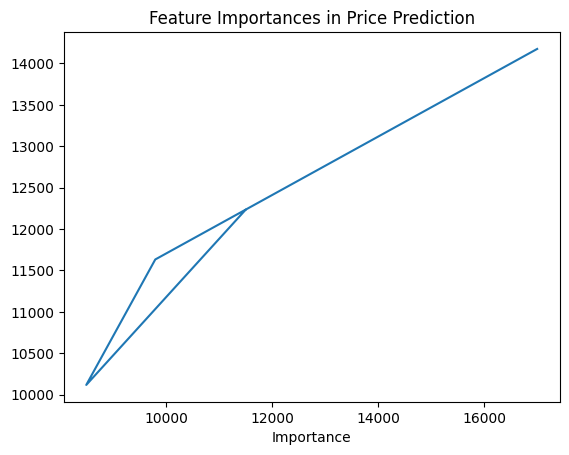

In [ ]:
import matplotlib.pyplot as plt

features = X_train.columns
importances = best_rf.feature_importances_

plt.plot(y_test, y_pred)  # or plt.scatter(...)
plt.xlabel("Importance")
plt.title("Feature Importances in Price Prediction")
plt.show()
